# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Dataset Overview
- The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.

- Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

# TASK
<b>The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.</b>

In [1]:
!pip install seaborn -U

    100% |████████████████████████████████| 215kB 23.6MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data preparation

In [3]:
portfolio.head()

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5

In [4]:
# null check
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [5]:
# one-hot encording for channels
for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0

In [6]:
for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0

In [7]:
portfolio

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  web  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  0.0    1.0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  1.0    1.0   
2  3f207df678b143eea3cee63160fa8bed  informational       0  1.0    1.0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  1.0    1.0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  1.0    1.0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3  1.0    1.0   
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2  1.0    1.0   
7  5a8bc65990b245e5a138643cd4eb9837  informational       0  0.0    1.0   
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5  1.0    1.0   
9  2906b810c7d4411798c6938adc9daaa5       discount       2  1.0    1.0   

   social  mobile  bogo  informational  discount  
0     1.0     1.0   1.0            0.0       0.0  
1     1.0     1.0   1.0            0.0       0.0  
2     0.0     1.0   0.0            1.0       0.0  
3     0.0     1.0   1.0            0.0       0.0  
4     0.0     0.0   0.0            0.0       1.0  
5     1.0     1.0   0.0            0.0       1.0  
6     1.0     1.0   0.0            0.0       1.0  
7     1.0     1.0   0.0            1.0       0.0  
8     1.0     1.0   1.0            0.0       0.0  
9     0.0     1.0   0.0            0.0       1.0

In [8]:
profile.head()

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [9]:
profile.shape

(17000, 5)

In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
# change into datetime
type(profile['became_member_on'][1]) # this is numpy int64 NOT strings

numpy.int64

In [12]:
# change the datatype into str
profile['became_member_on'] = profile['became_member_on'].astype(str)

In [13]:
# make a column for year
profile['membership_year'] = profile['became_member_on'].apply(lambda x: x[0:4])

In [14]:
# change into datetieme 
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

In [15]:
type(profile['became_member_on'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
# delete data with null
profile.dropna(axis='index', how='any', inplace=True)

In [17]:
profile.shape

(14825, 6)

In [18]:
profile.head()

age became_member_on gender                                id    income  \
1    55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
3    75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
5    68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   70000.0   
8    65       2018-02-09      M  389bc3fa690240e798340f5a15918d5c   53000.0   
12   58       2017-11-11      M  2eeac8d8feae4a8cad5a6af0499a211d   51000.0   

   membership_year  
1             2017  
3             2017  
5             2018  
8             2018  
12            2017

In [19]:
transcript.head()

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [20]:
# null check
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

# Inside of Data

In [21]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
channels         10 non-null object
difficulty       10 non-null int64
duration         10 non-null int64
id               10 non-null object
offer_type       10 non-null object
reward           10 non-null int64
web              10 non-null float64
email            10 non-null float64
social           10 non-null float64
mobile           10 non-null float64
bogo             10 non-null float64
informational    10 non-null float64
discount         10 non-null float64
dtypes: float64(7), int64(3), object(3)
memory usage: 1.1+ KB


In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
age                 14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
membership_year     14825 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 810.7+ KB


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
# merge profile with transcript
result_profile = pd.merge(profile, transcript, left_on = 'id', right_on = 'person')
result_profile.head()

age became_member_on gender                                id    income  \
0   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
1   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
2   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
3   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
4   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   

  membership_year           event                            person  time  \
0            2017     transaction  0610b486422d4921ae7d2bf64640c50b    18   
1            2017     transaction  0610b486422d4921ae7d2bf64640c50b   144   
2            2017  offer received  0610b486422d4921ae7d2bf64640c50b   408   
3            2017  offer received  0610b486422d4921ae7d2bf64640c50b   504   
4            2017     transaction  0610b486422d4921ae7d2bf64640c50b   528   

                                              value  
0                                 {'amount': 21.51}  
1                                 {'amount': 32.28}  
2  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
3  {'offer id': '3f207df678b143eea3cee63160fa8bed'}  
4                                 {'amount': 23.22}

In [25]:
value_df = pd.DataFrame()
value_df['person'] = result_profile.query('event == "offer completed"')['person']

# extract the amount of gained money from the offer
value_df['gained_money'] = result_profile.query('event == "offer completed"')['value'].apply(lambda x: x['reward'])

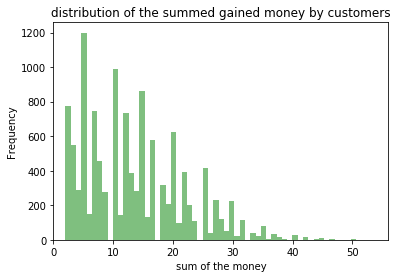

In [26]:
value_df.groupby('person')['gained_money'].sum().plot(kind='hist', 
                                                      bins=60, xlim=(0,56),
                                                     color='green', alpha=0.5);
plt.title('distribution of the summed gained money by customers');
plt.xlabel('sum of the money');

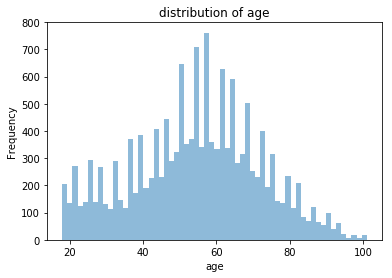

In [27]:
# distibution of age
profile['age'].plot(kind='hist', bins=60, alpha=0.5);
plt.xlabel('age');
plt.title('distribution of age');

In [28]:
profile[['age', 'income']].describe()

age         income
count  14825.000000   14825.000000
mean      54.393524   65404.991568
std       17.383705   21598.299410
min       18.000000   30000.000000
25%       42.000000   49000.000000
50%       55.000000   64000.000000
75%       66.000000   80000.000000
max      101.000000  120000.000000

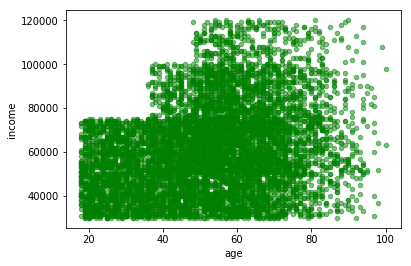

In [29]:
# relationships betweem income, age, and gender
# check the data in terms of M, F, O
# Male
profile.query('gender == "M"')[['age', 'income']].plot(kind='scatter', x='age', y='income', color='green', alpha=0.5);

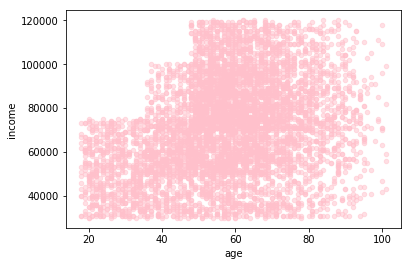

In [30]:
# Female
profile.query('gender == "F"')[['age', 'income']].plot(kind='scatter', x='age', y='income', color='pink', alpha=0.5);

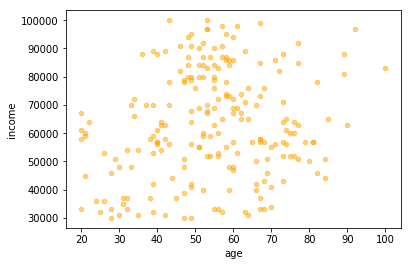

In [31]:
# O
profile.query('gender == "O"')[['age', 'income']].plot(kind='scatter', x='age', y='income', color='orange', alpha=0.5);

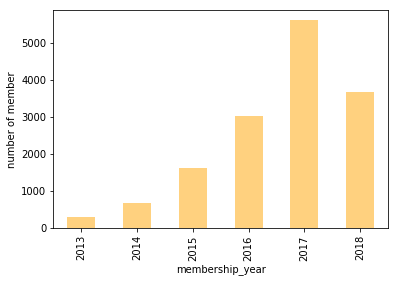

In [32]:
# how many members joined at certain year
profile.groupby('membership_year').size().plot(kind='bar', color='orange', alpha=0.5);
plt.ylabel('number of member');

In [33]:
result_profile.head()

age became_member_on gender                                id    income  \
0   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
1   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
2   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
3   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
4   55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   

  membership_year           event                            person  time  \
0            2017     transaction  0610b486422d4921ae7d2bf64640c50b    18   
1            2017     transaction  0610b486422d4921ae7d2bf64640c50b   144   
2            2017  offer received  0610b486422d4921ae7d2bf64640c50b   408   
3            2017  offer received  0610b486422d4921ae7d2bf64640c50b   504   
4            2017     transaction  0610b486422d4921ae7d2bf64640c50b   528   

                                              value  
0                                 {'amount': 21.51}  
1                                 {'amount': 32.28}  
2  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
3  {'offer id': '3f207df678b143eea3cee63160fa8bed'}  
4                                 {'amount': 23.22}

In [34]:
# what kind of customer who has the longer membership
for gender in ['M', 'F', 'O']:
    print('gender is ', gender)
    earliest_time = profile[['age', 'became_member_on', 'gender', 'income']].query('gender == @gender')['became_member_on'].min()
    print('the earliest time to become a member is ', earliest_time)
    
    age = profile[['age', 'became_member_on', 'gender', 'income']].query('gender == @gender & became_member_on == @earliest_time')['age']
    income = profile[['age', 'became_member_on', 'gender', 'income']].query('gender == @gender & became_member_on == @earliest_time')['income']
    
    print('age is', age.values[0], 'and income is ', income.values[0])
    print()

gender is  M
the earliest time to become a member is  2013-07-29 00:00:00
age is 64 and income is  69000.0

gender is  F
the earliest time to become a member is  2013-07-30 00:00:00
age is 58 and income is  55000.0

gender is  O
the earliest time to become a member is  2013-09-19 00:00:00
age is 40 and income is  56000.0



In [35]:
# sort by difficulty
portfolio.sort_values(by='difficulty')[portfolio.columns[~portfolio.columns.isin(['id'])]]

channels  difficulty  duration     offer_type  reward  \
2          [web, email, mobile]           0         4  informational       0   
7       [email, mobile, social]           0         3  informational       0   
3          [web, email, mobile]           5         7           bogo       5   
8  [web, email, mobile, social]           5         5           bogo       5   
5  [web, email, mobile, social]           7         7       discount       3   
0       [email, mobile, social]          10         7           bogo      10   
1  [web, email, mobile, social]          10         5           bogo      10   
6  [web, email, mobile, social]          10        10       discount       2   
9          [web, email, mobile]          10         7       discount       2   
4                  [web, email]          20        10       discount       5   

   web  email  social  mobile  bogo  informational  discount  
2  1.0    1.0     0.0     1.0   0.0            1.0       0.0  
7  0.0    1.0     1.0     1.0   0.0            1.0       0.0  
3  1.0    1.0     0.0     1.0   1.0            0.0       0.0  
8  1.0    1.0     1.0     1.0   1.0            0.0       0.0  
5  1.0    1.0     1.0     1.0   0.0            0.0       1.0  
0  0.0    1.0     1.0     1.0   1.0            0.0       0.0  
1  1.0    1.0     1.0     1.0   1.0            0.0       0.0  
6  1.0    1.0     1.0     1.0   0.0            0.0       1.0  
9  1.0    1.0     0.0     1.0   0.0            0.0       1.0  
4  1.0    1.0     0.0     0.0   0.0            0.0       1.0

In [36]:
# sort by reward
portfolio.sort_values(by='reward')[portfolio.columns[~portfolio.columns.isin(['id'])]]

channels  difficulty  duration     offer_type  reward  \
2          [web, email, mobile]           0         4  informational       0   
7       [email, mobile, social]           0         3  informational       0   
6  [web, email, mobile, social]          10        10       discount       2   
9          [web, email, mobile]          10         7       discount       2   
5  [web, email, mobile, social]           7         7       discount       3   
3          [web, email, mobile]           5         7           bogo       5   
4                  [web, email]          20        10       discount       5   
8  [web, email, mobile, social]           5         5           bogo       5   
0       [email, mobile, social]          10         7           bogo      10   
1  [web, email, mobile, social]          10         5           bogo      10   

   web  email  social  mobile  bogo  informational  discount  
2  1.0    1.0     0.0     1.0   0.0            1.0       0.0  
7  0.0    1.0     1.0     1.0   0.0            1.0       0.0  
6  1.0    1.0     1.0     1.0   0.0            0.0       1.0  
9  1.0    1.0     0.0     1.0   0.0            0.0       1.0  
5  1.0    1.0     1.0     1.0   0.0            0.0       1.0  
3  1.0    1.0     0.0     1.0   1.0            0.0       0.0  
4  1.0    1.0     0.0     0.0   0.0            0.0       1.0  
8  1.0    1.0     1.0     1.0   1.0            0.0       0.0  
0  0.0    1.0     1.0     1.0   1.0            0.0       0.0  
1  1.0    1.0     1.0     1.0   1.0            0.0       0.0

In [37]:
# pick up only numeric data
targets = ['difficulty', 'duration', 'reward']
portfolio_corr = portfolio[targets].corr()

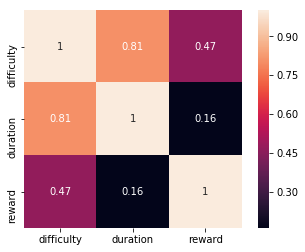

In [38]:
# correlation betwene reward, duration and difficulty
sns.heatmap(portfolio_corr, square=True, annot=True);

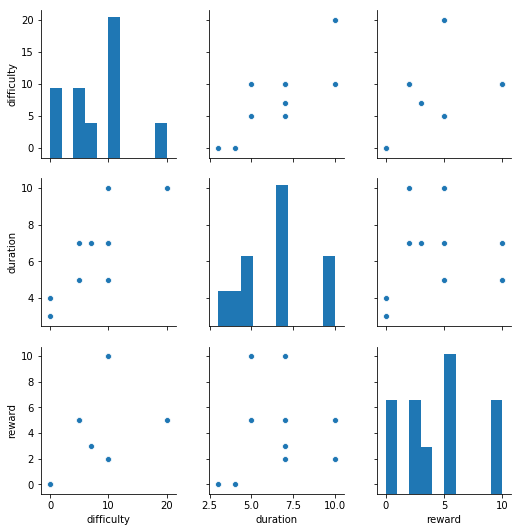

In [39]:
# plot of the relation
sns.pairplot(portfolio[targets]);
# if difficulty is increased, the duration tends to increase

#### Correlation
- It looks `difficulty` and `duration` relate more than others. 
- When `difficulty` is increased, `duration` tends to be longer.

In [40]:
portfolio.groupby(['difficulty', 'duration']).size()

difficulty  duration
0           3           1
            4           1
5           5           1
            7           1
7           7           1
10          5           1
            7           2
            10          1
20          10          1
dtype: int64

## At this point, here is what I think. 
- Customer who spends more money doesn't care about the offers that much. This tendency could tell you that customers who spends more money at Starbucks have a kind of loyalty not depending on discounting or some offers. However, customer who doesn't spend money as much as the former might have the tendency to visit at Starbucks because of the offer or discounting.

- Next thing to reveal is the tendency of the offer.

# what kind customers can get certain kinds offer?



In [41]:
portfolio['difficulty'].unique() # the variation of `difficulty`

array([10,  0,  5, 20,  7])

In [42]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

## bogo group
- buy-one-get-one
- a user needs to spend a certain amount to get a reward equal to that threshold amount. 

In [43]:
# For bogo group
bogo_gr = portfolio.query('offer_type == "bogo"')
bogo_gr

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
3          [web, email, mobile]           5         7   
8  [web, email, mobile, social]           5         5   

                                 id offer_type  reward  web  email  social  \
0  ae264e3637204a6fb9bb56bc8210ddfd       bogo      10  0.0    1.0     1.0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0       bogo      10  1.0    1.0     1.0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       bogo       5  1.0    1.0     0.0   
8  f19421c1d4aa40978ebb69ca19b0e20d       bogo       5  1.0    1.0     1.0   

   mobile  bogo  informational  discount  
0     1.0   1.0            0.0       0.0  
1     1.0   1.0            0.0       0.0  
3     1.0   1.0            0.0       0.0  
8     1.0   1.0            0.0       0.0

In [44]:
bogo_gr['difficulty'].unique() # bogo group has 10 or 5 difficulty

array([10,  5])

In [45]:
channels = ['web', 'email', 'social', 'mobile']
bogo_gr[channels].sum() # most customers have all channel

web       3.0
email     4.0
social    3.0
mobile    4.0
dtype: float64

In [46]:
# how about the duration (time for offer to be open, in days)
bogo_gr['duration'].unique()

array([7, 5])

In [47]:
bogo_gr['duration'].median() # median is 6 days

6.0

## informational group
- there is no reward, but neither is there a requisite amount that the user is expected to spend

In [48]:
# informational group
info_gr = portfolio.query('offer_type == "informational"')
info_gr

channels  difficulty  duration  \
2     [web, email, mobile]           0         4   
7  [email, mobile, social]           0         3   

                                 id     offer_type  reward  web  email  \
2  3f207df678b143eea3cee63160fa8bed  informational       0  1.0    1.0   
7  5a8bc65990b245e5a138643cd4eb9837  informational       0  0.0    1.0   

   social  mobile  bogo  informational  discount  
2     0.0     1.0   0.0            1.0       0.0  
7     1.0     1.0   0.0            1.0       0.0

In [49]:
info_gr['difficulty'].unique() # difficulty and reward is 0 
# which means you don't need to spend much money to get informational offer

array([0])

In [50]:
info_gr[channels].sum() # web and social are lower
# they tend to have just email and mobile

web       1.0
email     2.0
social    1.0
mobile    2.0
dtype: float64

In [51]:
# how many days to take to be opened
info_gr['duration'].unique()

array([4, 3])

In [52]:
info_gr['duration'].median() # median is 3.5 days

3.5

## discount group
- a user gains a reward equal to a fraction of the amount spent.

In [53]:
disc_gr = portfolio.query('offer_type == "discount"')
disc_gr

channels  difficulty  duration  \
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
9          [web, email, mobile]          10         7   

                                 id offer_type  reward  web  email  social  \
4  0b1e1539f2cc45b7b9fa7c272da2e1d7   discount       5  1.0    1.0     0.0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2   discount       3  1.0    1.0     1.0   
6  fafdcd668e3743c1bb461111dcafc2a4   discount       2  1.0    1.0     1.0   
9  2906b810c7d4411798c6938adc9daaa5   discount       2  1.0    1.0     0.0   

   mobile  bogo  informational  discount  
4     0.0   0.0            0.0       1.0  
5     1.0   0.0            0.0       1.0  
6     1.0   0.0            0.0       1.0  
9     1.0   0.0            0.0       1.0

<b> Even `difficulty` is highest, 20, the reward for those customer is just `5`.</b>

In [54]:
disc_gr[channels].sum() # all has web and email

web       4.0
email     4.0
social    2.0
mobile    3.0
dtype: float64

In [55]:
# how about separating data in terms of `difficulty`?
for difficulty in portfolio['difficulty'].unique():
    print('---')
    print('difficulty is ', difficulty)
    display(portfolio.query('difficulty == @difficulty')[['duration', 'offer_type']])

---
difficulty is  10


duration offer_type
0         7       bogo
1         5       bogo
6        10   discount
9         7   discount

---
difficulty is  0


duration     offer_type
2         4  informational
7         3  informational

---
difficulty is  5


duration offer_type
3         7       bogo
8         5       bogo

---
difficulty is  20


duration offer_type
4        10   discount

---
difficulty is  7


duration offer_type
5         7   discount

In [56]:
# check the relationship between offers, difficulty(the amonut of money they spent) and duration
portfolio[['difficulty', 'bogo', 'informational', 'discount', 'duration']]

difficulty  bogo  informational  discount  duration
0          10   1.0            0.0       0.0         7
1          10   1.0            0.0       0.0         5
2           0   0.0            1.0       0.0         4
3           5   1.0            0.0       0.0         7
4          20   0.0            0.0       1.0        10
5           7   0.0            0.0       1.0         7
6          10   0.0            0.0       1.0        10
7           0   0.0            1.0       0.0         3
8           5   1.0            0.0       0.0         5
9          10   0.0            0.0       1.0         7

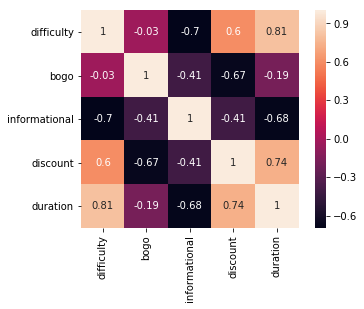

In [57]:
sns.heatmap(portfolio[['difficulty', 'bogo', 'informational', 'discount', 'duration']].corr(),
            square=True, annot=True);

# What I think.... 
- <big>`bogo` and `informational` seems like it doesn't relate with any features. Does it mean these two offers are randomly offered?!</big>

- <big>`discount` is relate with `difficulty` and `duration`. This might means the more money customers spend, the posibility of getting `discount` offer becomes higher. Starbucks discounts for customers who spends more. <br>However `duration` is also positively related. So customers who spends more money might not carefully check `discount` offers. This might show `discount` doesn't motivate those kind of  customers. <br>Maybe this offer is not attractive for customers who can spends more money at Starbucks.</big>

- <big>`duration` and `difficulty` are positively related. Customers who spends more money might not care about offers or they might have a difficulty to access to the offer as soon as they can. Maybe they don't check their email or mobile in every 1 hour like younger does. So this relationships needs to be analyzed in terms of age, how much they use web, mobile and email etc.</big>


In [58]:
result_profile

age became_member_on gender                                id  \
0        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
1        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
2        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
3        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
4        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
5        55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b   
6        75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
7        75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
8        75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
9        75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
10       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
11       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
12       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
13       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
14       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
15       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
16       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
17       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
18       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
19       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
20       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
21       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
22       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
23       75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef   
24       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
25       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
26       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
27       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
28       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
29       68       2018-04-26      M  e2127556f4f64592b11af22de27a7932   
...     ...              ...    ...                               ...   
272732   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272733   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272734   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272735   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272736   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272737   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272738   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272739   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272740   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272741   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272742   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272743   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272744   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272745   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272746   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272747   83       2016-03-07      F  9dc1421481194dcd9400aec7c9ae6366   
272748   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272749   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272750   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272751   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272752   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272753   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf068   
272754   62       2017-07-22      F  e4052622e5ba45a8b96b59aba68cf

mean  54.644645006
min  18
max  101


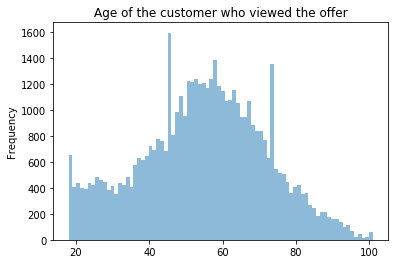

In [59]:
# who viewd the offer?
data = result_profile.query('event == "offer viewed"')
data['age'].plot(kind='hist', bins=80, alpha=0.5);
plt.title('Age of the customer who viewed the offer');
print('mean ', data['age'].mean())
print('min ', data['age'].min())
print('max ', data['age'].max())

mean  52.7139653267
min  18
max  101


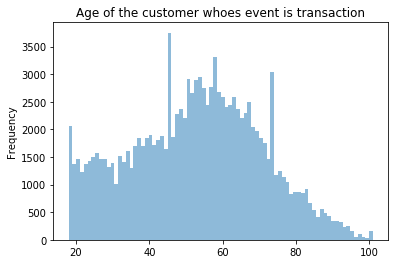

In [60]:
# who purchased by the offer
data = result_profile.query('event == "transaction"')
data['age'].plot(kind='hist', bins=80, alpha=0.5);
plt.title('Age of the customer whoes event is transaction');
print('mean ', data['age'].mean())
print('min ', data['age'].min())
print('max ', data['age'].max())

In [61]:
# how much money was spent with the offier?
transaction_df = result_profile.query('event == "transaction"')
transaction_df['value'].head()

0     {'amount': 21.51}
1     {'amount': 32.28}
4     {'amount': 23.22}
8     {'amount': 19.89}
10    {'amount': 17.78}
Name: value, dtype: object

In [62]:
# make a column for the amonut of money in the purchase
transaction_df['amount'] = transaction_df['value'].apply(lambda x: list(x.values())[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
transaction_df.head()

age became_member_on gender                                id    income  \
0    55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
1    55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
4    55       2017-07-15      F  0610b486422d4921ae7d2bf64640c50b  112000.0   
8    75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
10   75       2017-05-09      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0   

   membership_year        event                            person  time  \
0             2017  transaction  0610b486422d4921ae7d2bf64640c50b    18   
1             2017  transaction  0610b486422d4921ae7d2bf64640c50b   144   
4             2017  transaction  0610b486422d4921ae7d2bf64640c50b   528   
8             2017  transaction  78afa995795e4d85b5d9ceeca43f5fef   132   
10            2017  transaction  78afa995795e4d85b5d9ceeca43f5fef   144   

                value  amount  
0   {'amount': 21.51}   21.51  
1   {'amount': 32.28}   32.28  
4   {'amount': 23.22}   23.22  
8   {'amount': 19.89}   19.89  
10  {'amount': 17.78}   17.78

In [65]:
transaction_df.groupby('id')['amount'].sum().sort_values(ascending=False) # 14492 unique customer 

id
3c8d541112a74af99e88abbd0692f00e    1608.69
f1d65ae63f174b8f80fa063adcaa63b7    1365.66
ae6f43089b674728a50b8727252d3305    1327.74
626df8678e2a4953b9098246418c9cfa    1321.42
73afdeca19e349b98f09e928644610f8    1319.97
52959f19113e4241a8cb3bef486c6412    1292.86
ad1f0a409ae642bc9a43f31f56c130fc    1258.19
d240308de0ee4cf8bb6072816268582b    1251.99
946fc0d3ecc4492aa4cc06cf6b1492c3    1232.40
6406abad8e2c4b8584e4f68003de148d    1211.76
6cf884a6c5ae4b2daccb6d3108028fef    1165.26
8c6b2a81cb294c28b740e9c459ab7767    1154.75
5ecaea5c8bf44ae4a65838d9d066c909    1153.11
4d0ebb94a5a94fe6afd9350c7b1477e4    1152.94
dce784e26f294101999d000fad9089bb    1151.86
05bedc6bbcc64a41b1745f6efe00776d    1148.92
a73cf044395d46ea804f688490ad9227    1128.22
ca715b3f17e24692b18f3cd90b9bf232    1118.78
c7a5d7bab83a4d82a7f977b3d586f3d4    1118.73
5dfdad4241764dfe959f51b7460e42b1    1112.66
7d7f271652d244f78b97c73cd734c553    1106.17
1c05e4a68fc04d3da27454cb7eaa6144    1099.28
454b00bdd77c4f588eb9f6cafd81d

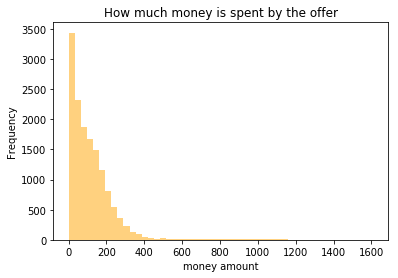

In [73]:
transaction_df.groupby('id')['amount'].sum().sort_values(ascending=False).plot(kind='hist', color='orange',
                                                                              alpha=0.5, bins=50);
plt.xlabel('money amount');
plt.title('How much money is spent by the offer');

In [75]:
# mean and median in all
print('mean ', transaction_df.groupby('id')['amount'].sum().mean())
print('median ', transaction_df.groupby('id')['amount'].sum().median())

mean  119.717250897
median  89.86


In [76]:
# mean and median in each customer
print('mean ', transaction_df.groupby('id')['amount'].mean())
print('median ', transaction_df.groupby('id')['amount'].median())

mean  id
0009655768c64bdeb2e877511632db8f    15.950000
0011e0d4e6b944f998e987f904e8c1e5    15.892000
0020c2b971eb4e9188eac86d93036a77    24.607500
0020ccbbb6d84e358d3414a3ff76cffd    12.837500
003d66b6608740288d6cc97a6903f4f0     2.685556
00426fe3ffde4c6b9cb9ad6d077a13ea     4.030000
004b041fbfe44859945daa2c7f79ee64    23.060000
004c5799adbf42868b9cff0396190900    28.948333
005500a7188546ff8a767329a2f7c76a     5.090000
0056df74b63b4298809f0b375a304cf4    28.828000
00715b6e55c3431cb56ff7307eb19675    25.008000
0082fd87c18f45f2be70dbcbb0fb8aad    17.407143
00840a2ca5d2408e982d56544dc14ffd     3.701765
00857b24b13f4fe0ad17b605f00357f5     1.565000
008d7088107b468893889da0ede0df5c     2.311429
0091d2b6a5ea4defaa8393e4e816db60    23.263333
0099bf30e4cb4265875266eb3eb25eab    11.758889
00a794f62b9a48beb58f8f6c02c2f1a6    15.127273
00ae03011f9f49b8a4b3e6d416678b0b    27.256250
00aee28bbb3848dd8a31f0c91dc267dd     4.106000
00b18b535d6d4f779dea4dc9ac451478    26.650000
00b3400e4ff64ee68ce9ada1d

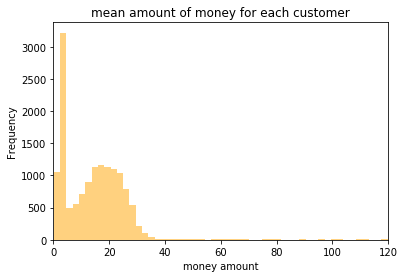

In [95]:
transaction_df.groupby('id')['amount'].mean().plot(kind='hist', color='orange',
                                                  bins=200, alpha=0.5);
plt.xlim(0,120);
plt.title('mean amount of money for each customer')
plt.xlabel('money amount');

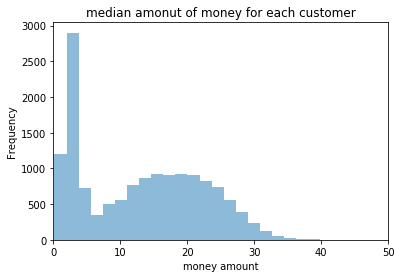

In [99]:
transaction_df.groupby('id')['amount'].median().plot(kind='hist', bins=250,
                                                    alpha=0.5);
plt.xlim(0,50);
plt.title('median amonut of money for each customer');
plt.xlabel('money amount');

In [100]:
# min
transaction_df.groupby('id')['amount'].median().min() 
# min of median amount of money is about 0.15

0.14999999999999999

In [103]:
# extract customer who spent more than 0.15 in a purchase
medi_customer = transaction_df[transaction_df['amount'] >= 0.15]

In [149]:
# data of unique customer in medi_customer
customer_features = medi_customer[['age', 'gender', 'id', 'income','membership_year']].drop_duplicates()

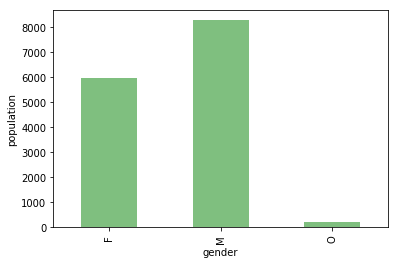

In [150]:
# composition in gender
customer_features.groupby('gender').size().plot(kind='bar', color='green', alpha=0.5);
plt.ylabel('population');
# men is lager portion

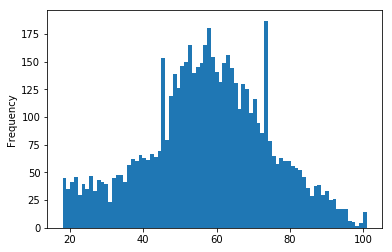

In [151]:
# composition in age
# female
customer_features.query('gender == "F"')['age'].plot(kind='hist', bins=80);
# middle age group is bigger

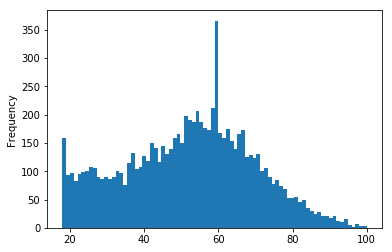

In [152]:
# male
customer_features.query('gender == "M"')['age'].plot(kind='hist', bins=80);
# younger age (from 10s~30s) is bigger than in female data

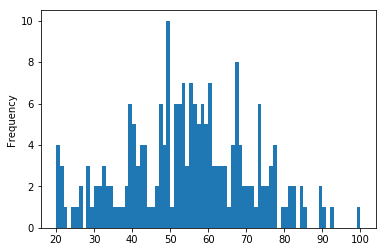

In [153]:
# O
customer_features.query('gender == "O"')['age'].plot(kind='hist', bins=80);

In [154]:
# median income in female 
customer_features.query('gender == "F"')['income'].median() # 71000

71000.0

In [155]:
# mean income in female 
customer_features.query('gender == "F"')['income'].mean() # about 71132

71132.154179876525

In [156]:
# median income in male 
customer_features.query('gender == "M"')['income'].median() # 59000

59000.0

In [157]:
# mean income in male 
customer_features.query('gender == "M"')['income'].mean() # about 61001

61001.928872814948

##  Results of analysis for a group from the perspective of age, gender and income
<big>male's income tends to be lower than female. <br>
    This might cause more yonger male customers make purchase with the offer.</big>

In [172]:
# focus on younger male group
# how much money did they spent?
# get their id
younger_male_id = customer_features.query('gender == "M" and age < 40')['id']

In [173]:
# extract data with younger_male_id
younger_male_df = transaction_df[transaction_df['id'].isin(younger_male_id)]

In [200]:
# top 10 for the sum of the money they spent by one younger male customer
top10_sum_id = younger_male_df.groupby('id')['amount'].sum().sort_values(ascending=False)[0:10] # top 10

In [205]:
younger_male_df[younger_male_df['id'] == top10_sum_id.index[0]] 
# he spent more money with the offers
# income 64000
# age 32
# membership year 2018

age became_member_on gender                                id  \
216495   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216497   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216498   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216500   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216502   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216506   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216508   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216511   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216513   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216515   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216519   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216520   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   
216523   32       2018-06-19      M  f1d65ae63f174b8f80fa063adcaa63b7   

         income membership_year        event  \
216495  64000.0            2018  transaction   
216497  64000.0            2018  transaction   
216498  64000.0            2018  transaction   
216500  64000.0            2018  transaction   
216502  64000.0            2018  transaction   
216506  64000.0            2018  transaction   
216508  64000.0            2018  transaction   
216511  64000.0            2018  transaction   
216513  64000.0            2018  transaction   
216515  64000.0            2018  transaction   
216519  64000.0            2018  transaction   
216520  64000.0            2018  transaction   
216523  64000.0            2018  transaction   

                                  person  time               value  amount  
216495  f1d65ae63f174b8f80fa063adcaa63b7    12  {'amount': 639.59}  639.59  
216497  f1d65ae63f174b8f80fa063adcaa63b7    30   {'amount': 11.51}   11.51  
216498  f1d65ae63f174b8f80fa063adcaa63b7   138   {'amount': 18.79}   18.79  
216500  f1d65ae63f174b8f80fa063adcaa63b7   192   {'amount': 13.23}   13.23  
216502  f1d65ae63f174b8f80fa063adcaa63b7   288   {'amount': 12.12}   12.12  
216506  f1d65ae63f174b8f80fa063adcaa63b7   372    {'amount': 7.62}    7.62  
216508  f1d65ae63f174b8f80fa063adcaa63b7   396   {'amount': 16.23}   16.23  
216511  f1d65ae63f174b8f80fa063adcaa63b7   474   {'amount': 13.11}   13.11  
216513  f1d65ae63f174b8f80fa063adcaa63b7   486   {'amount': 10.83}   10.83  
216515  f1d65ae63f174b8f80fa063adcaa63b7   528  {'amount': 582.69}  582.69  
216519  f1d65ae63f174b8f80fa063adcaa63b7   594    {'amount': 9.52}    9.52  
216520  f1d65ae63f174b8f80fa063adcaa63b7   600   {'amount': 12.15}   12.15  
216523  f1d65ae63f174b8f80fa063adcaa63b7   678   {'amount': 18.27}   18.27

In [181]:
younger_male_df.groupby('id').size().sort_values(ascending=False).max()
# max time of make purchases is 35 by one customer!

35

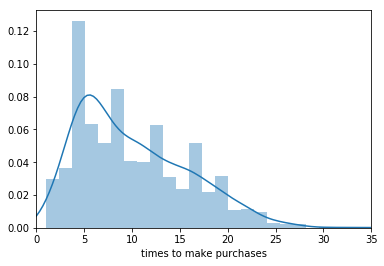

In [195]:
sns.distplot(younger_male_df.groupby('id').size().sort_values(ascending=False));
plt.xlabel('times to make purchases');
plt.xlim(0,35);
# median for times is about 6 times

- <big>Male: younger male tend to use and make purchase with offers.Maybe how high income is doesn't matter.</big>
- <big>Female: middle age female tend to use and make purchase with offers. Maybe how high income matters.</big>

# Results
- <big>What kind of group to send offers</big>
 - Younger male and middle age female
     - But in terms of how often they check mobiles, email, website, and social, the reflection of the offers could be late.
     - This might relate with age. So recipt or paper cards are better to give offers to those customers who has longer durations.
  
 - Customer who spents much money might not care about existed offers. 